In [1]:
import sys
import os
import warnings
import glob
warnings.filterwarnings('ignore')  # ignore warnings, like ZeroDivision

# Go up one directory from 'notebooks/' to project root
project_root = os.path.abspath('..')
sys.path.append(project_root)

os.getcwd()

'/home/echerif/Projects/SemiSup_Project/Semi_supervised_template/notebooks'

In [ ]:
from src.utils_data import *
from src.transformation_utils import *
from src.utils_all import *
from src.GAN.SrGAN_RTM_trainer import *

In [7]:
from sklearn.model_selection import train_test_split
import wandb
import pickle

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

# Check if GPU is available
if torch.cuda.is_available():
    # Set the device to GPU
    device = torch.device("cuda")
    print("GPU is available. Using GPU for computation.")
else:
    # If GPU is not available, fall back to CPU
    device = torch.device("cpu")
    print("GPU is not available. Using CPU for computation.")

2.5.1
True
GPU is available. Using GPU for computation.


In [4]:
seed_all(seed=4)

In [5]:
percentage_tr = 1
batch_size = 128
ls_tr = ["cab", "cw", "cm", "LAI", "cp", "cbc", "car", "anth"]

perc = 100
main_path = '/home/mila/e/eya.cherif/scratch/Gans_models/checkpoints_Gan_NoRTM_250307_0705_{}labels_140'.format(perc)

# # ########## Unlabeled #########
directory_path = os.path.join(project_root, "Splits")
file_paths = glob.glob(os.path.join(directory_path, "*.csv"))
file_paths = file_paths[:int(percentage_tr*len(file_paths))]

################ Data ###############
path_data_lb = os.path.join(project_root, "Datasets/50SHIFT_all_lb_prosailPro.csv") ##50SHIFT_all_lb_prosailPro 49_all_lb_prosailPro

# Evaluation

In [8]:
db_lb_all = pd.read_csv(path_data_lb, low_memory=False).drop(['Unnamed: 0'], axis=1)   

### external
groups = db_lb_all.groupby('dataset')

val_ext_idx = list(groups.get_group(32).index)+list(groups.get_group(3).index)
samples_val_ext = db_lb_all.loc[val_ext_idx,:]
db_lb_all.drop(val_ext_idx, inplace=True)

X_labeled, y_labeled, _ = data_prep_db(db_lb_all, ls_tr, weight_sample=True)
metadata = db_lb_all.iloc[:, :8]  # The metadata (dataset of origin)


red_ed = X_labeled.loc[:,750]
red_end = X_labeled.loc[:,1300]
red1000_ = X_labeled.loc[:,1000]

idx = X_labeled[(red_end>red1000_) & (red_ed>red1000_)].index

if(len(idx)>0):
    # X_labeled.loc[idx,:].T.plot(legend=False)
    X_labeled.drop(idx, inplace=True)
    y_labeled.drop(idx, inplace=True)
    metadata.drop(idx, inplace=True)


# Split labeled data into train (80%), validation (10%), and test (10%)
X_train, X_val= train_test_split(X_labeled, test_size=0.2, stratify=metadata.dataset, random_state=300)

y_train = y_labeled.loc[X_train.index,:]
y_val = y_labeled.loc[X_val.index,:]

meta_train = metadata.loc[X_train.index,:]
meta_val = metadata.loc[X_val.index,:]
###################

# Scaler ###
# open a file, where you stored the pickled data
file = open(os.path.join(main_path, 'scaler_all_{}.pkl'.format(perc)), 'rb') 

# dump information to that file
scaler_model = pickle.load(file)

# # Create the dataset
# train_dataset = SpectraDataset(X_train, y_train, meta_train, augmentation=True, aug_prob=0.8)
# # Define DataLoader with the custom collate function for fair upsampling
# train_dataset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SpectraDataset(X_train=X_val, y_train=y_val, meta_train=meta_val, augmentation=False)
# Create DataLoader for the test dataset
valid_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Create the dataset
# untrain_dataset = MultiFileAugmentedCSVDataset(file_paths, chunk_size=1000, augmentation=True, aug_prob=0.5, scale=False) ## No scaling of specra!!!
# unlabeled_dataset_loader = DataLoader(untrain_dataset, batch_size=batch_size, 
#                         shuffle=True
#                        )

FileNotFoundError: [Errno 2] No such file or directory: '/home/mila/e/eya.cherif/scratch/Gans_models/checkpoints_Gan_NoRTM_250307_0705_100labels_140/scaler_all_100.pkl'

In [10]:
######
# Example dictionary for updating the Settings class

settings_dict = {
    'checkpoint_dir': None, #checkpoint_dir,
    'train_loader': None,
    'valid_loader': valid_loader,
    'unlabeled_loader': None, #unlabeled_dataset_loader,
    
    'scaler_model': scaler_model,
    'n_lb': y_train.shape[1], #8,
    'input_shape': 1720, #1720,
    'type':'full',
    'latent_dim': 100,
    'learning_rate': 5e-5,
    'weight_decay': 1e-4,
    
    'n_epochs': 700,
    'batch_size': None,
    
    'rtm_D': True,
    'rtm_G': True,
    
    'lambda_fk': 1.0,
    'lambda_un': 10.0,
    
    'labeled_loss_multiplier': 1.0,
    'matching_loss_multiplier': 1.0,
    'contrasting_loss_multiplier': 1.0,
    
    'gradient_penalty_on': True,
    'gradient_penalty_multiplier': 10.0,
    'srgan_loss_multiplier': 1.0,
    
    'early_stop': True,
    'early_stopping': None,
    'patience': 10,
    'logger': None,
    'log_epoch': 10,
    
    'mean_offset': 0,
    'normalize_fake_loss': False,
    'normalize_feature_norm': False,
    
    'contrasting_distance_function': nn.CosineEmbeddingLoss(),
    'matching_distance_function': nn.CosineEmbeddingLoss(),
    'labeled_loss_function': HuberCustomLoss(threshold=1.0),

    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}


input_shape = X_train.shape[1] #fr_sup.shape[1]
n_lb = y_train.shape[1] #y_sup.shape[1]

settings = Settings() ## set the settings first
# Update settings using the dictionary
settings.update_from_dict(settings_dict)

In [11]:
test = SrGAN_RTM(settings) #SrGAN SrGAN_RTM Experiment

test.dataset_setup()
# test.model_setup(test.settings.latent_dim, test.settings.input_shape, test.settings.n_lb)
test.model_setup()
test.transformation_setup()

path_model = os.path.join(main_path, 'best_model_G.h5') #checkpoints_Gan_NoRTM_240930_0927_20.0labels
test.G = torch.load(path_model,map_location=torch.device('cpu'))



path_model = os.path.join(main_path, 'best_model.h5')  #checkpoints_Gan_NoRTM_240930_0500_20.0labels
test.D = torch.load(path_model,map_location=torch.device('cpu'))


test.G.eval()
test.D.eval()
test.G.to(device)
test.D.to(device)

Discriminator(
  (conv1): Conv1d(1, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv3): Conv1d(128, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (activation): LeakyReLU(negative_slope=0.2)
  (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=27520, out_features=8, bias=True)
)

In [12]:
# Calculate the number of trainable parameters
num_trainable_params = sum(p.numel() for p in test.D.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {num_trainable_params}")

Number of trainable parameters: 319496


<Axes: >

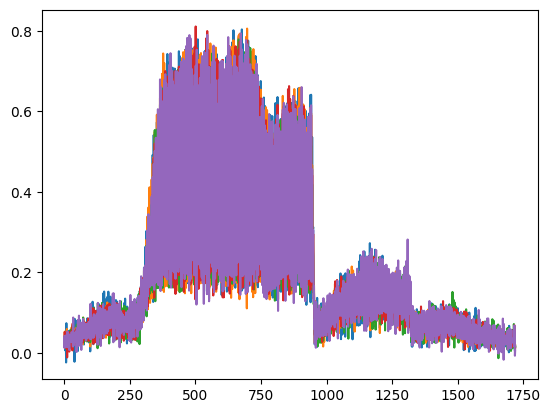

In [13]:
##### Visualize the generator signal 
#import matplotlib.pyplot as plt

# Generate spectra
z_train = torch.randn(5, test.settings.latent_dim).to(device)

gen_spectra = test.G(z_train) #test.G
# gen_spectra.squeeze(dim=1).cpu().detach().numpy().shape
pd.DataFrame(gen_spectra.squeeze(dim=1).cpu().detach().numpy()).T.plot(legend=False)

In [64]:
########### prediction on evaluation

preds = torch.empty(0,8).to(device)
ori = torch.empty(0,8).to(device)

val_train_iterator = iter(test.valid_loader) 

with torch.no_grad():
    for val_examples, val_labels, _ in val_train_iterator:
        val_examples = val_examples.unsqueeze(dim=1)[:,:,:-1].float().to(gpu)
        
        val_labels = val_labels.float().to(gpu)
    
        test.eval_mode()

        if(test.transformation_layer_inv is not None): #test.settings.scaler_model
            preds_D = test.transformation_layer_inv(test.D(val_examples)[0]) ### shoud keep the sam eorder of labels !!!
            # ori_D = test.transformation_layer_inv(val_labels) ### shoud keep the sam eorder of labels !!!
            
        elif(test.settings.scaler_list is not None):
            preds_D = torch.tensor(test.settings.scaler_list.inverse_transform(test.D(val_examples)[0].cpu().detach().numpy()), dtype=torch.float32).requires_grad_(True)
            # ori_D = torch.tensor(test.settings.scaler_list.inverse_transform(val_labels.cpu().detach().numpy()), dtype=torch.float32).requires_grad_(True)
        else:
            preds_D = test.D(val_examples)[0]
            # ori_D = val_labels.clone()
        
        ori = torch.cat((ori.data, val_labels.data), dim=0)
        preds = torch.cat((preds.data, preds_D.data), dim=0)


ori_lb = pd.DataFrame(ori.cpu(), columns=ls_tr[:])#[original_dict.keys()#
display(ori_lb.describe())

df_tr_val = pd.DataFrame(preds.cpu(), columns=ls_tr[:])#[original_dict.keys()#
display(df_tr_val.describe())

,cab,cw,cm,LAI,cp,cbc,car,anth
count,396.000000,424.000000,736.000000,284.000000,555.000000,555.000000,325.000000,73.000000
mean,37.838181,0.013924,0.008714,3.246530,0.000769,0.008235,8.163689,1.328033
std,13.576089,0.008998,0.006341,1.769485,0.000441,0.006393,2.867902,0.435457
min,4.448305,0.000133,0.000031,0.080000,0.000007,0.000024,1.182576,0.668249
25%,26.817780,0.008742,0.005205,1.784167,0.000501,0.005193,6.044010,1.009537
50%,36.388645,0.011581,0.007490,3.271715,0.000746,0.006759,8.066246,1.219571
75%,47.984413,0.017414,0.010012,4.589347,0.000994,0.009147,9.818449,1.601554
max,78.123940,0.056263,0.049981,7.136380,0.004204,0.045777,19.568256,2.981117


,cab,cw,cm,LAI,cp,cbc,car,anth
count,1127.000000,1108.000000,1.127000e+03,1105.000000,1.120000e+03,1.127000e+03,1127.000000,1127.000000
mean,37.941025,0.015511,7.469037e-03,3.210602,6.501240e-04,6.821613e-03,8.531799,1.411834
std,12.749763,0.008532,4.819652e-03,1.517931,3.374142e-04,4.986238e-03,2.644333,0.460674
min,6.549192,0.000002,2.513525e-07,0.080285,1.838406e-07,4.764179e-08,2.074310,0.384451
25%,28.652096,0.009974,4.550749e-03,2.130894,4.359993e-04,3.838214e-03,6.747028,1.090276
50%,36.555222,0.013952,6.469474e-03,3.250519,6.141661e-04,5.866318e-03,8.150873,1.335204
75%,46.042088,0.019143,9.223744e-03,4.175462,8.160630e-04,8.394395e-03,10.007927,1.661663
max,161.869476,0.082937,3.517488e-02,8.537584,2.936304e-03,4.674224e-02,19.856749,3.472300


In [ ]:
#### calculate the evaluation score of the regression ##

eval_metrics(ori_lb, df_tr_val)

,r2_score,RMSE,nRMSE (%),MAE,Bias
cab,0.294254,11.390681,20.957668,7.758101,0.987487
cw,0.518907,0.006234,14.755122,0.004032,0.000693
cm,0.594809,0.004034,11.792271,0.002337,0.000741
LAI,0.474631,1.275322,19.081830,0.934846,0.392545
cp,0.471755,0.000320,12.642964,0.000201,0.000060
cbc,0.633060,0.003869,11.412976,0.002242,0.000568
car,0.535263,1.952084,13.776212,1.382351,0.181592
anth,-0.070770,0.447505,23.064097,0.327563,-0.093728


In [41]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

# import seaborn as sns

# size = 5.7
# quantile_vis = 1
# # test_tr = Traits[:-1]
# figsize = (10,4)

# plt.rc('font', size=size) #5.7
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.linewidth'] = 0.5

# a = 2 # number of rows
# b = 5  # number of columns
# c = 1  # initialize plot counter

# fig = plt.figure(figsize = figsize,dpi=300 ,constrained_layout=True)
# Traits = test_tr = list(ori_lb.columns)

# for tr in range(len(test_tr)):
        
#     pred = df_tr_val.iloc[:,tr]
#     true = ori_lb.iloc[:,tr]
    
#     norm = (np.nanquantile(true, 0.99) - np.nanquantile(true, 0.01))
    
#     f = pred.copy().reset_index(drop=True)
#     y = true.copy().reset_index(drop=True)
    
#     idx = np.union1d(f[f.isna()].index,y[y.isna()].index)
    
#     f.drop(idx, axis = 0, inplace=True)
#     y.drop(idx, axis = 0, inplace=True)
    
#     r2 = r2_score(y,f)
#     nrmse = math.sqrt(mean_squared_error(y,f))/norm
#     nmae = mean_absolute_error(y,f)/norm

#     ax1 = plt.subplot(a, b, c)
#     plt.axis('square')
    
#     lim_max = min(f.quantile(quantile_vis),y.quantile(quantile_vis)) 
#     lim_min = max(f.quantile(1-quantile_vis),y.quantile(1-quantile_vis))
    
#     #######
#     ax1.set_xlim(lim_min,lim_max)
#     ax1.set_ylim(ax1.get_xlim())
#     ax1.set_aspect('equal', adjustable='box')

#     sns.lineplot(x=(lim_min,lim_max), y=(lim_min,lim_max), ax = ax1, color='black',legend='full', linestyle='dashed')

#     sns.regplot(x= pred, color='b', y=true,fit_reg= True,ax=ax1, ci=False, scatter_kws={"color": "blue", 'alpha':0.3})
#     # sns.regplot(x= f, y=y, color='b', fit_reg= True, ax=ax1, scatter=False)

#     ann = 'R² = {0:.2f} \n nRMSE = {1:.2f}'.format(r2, nrmse)
    
#     ax1.annotate(ann,
#     xy=(0.55,0.01),
#     xycoords='axes fraction',
#     horizontalalignment='left',
#     verticalalignment='bottom',size=size)

#     ann = test_tr[tr]
#     ax1.set_title(ann, y=1.1, pad=-5, fontdict = {'fontsize':size,
#     'horizontalalignment': 'center', 'fontweight':'bold'})
    
#     plt.xlabel(" ")
#     plt.ylabel(" ")
    
#     c+=1

# fig.supxlabel('Predictions', size=8, fontweight='bold', ha='center')
# fig.supylabel('Observations', size=8, fontweight='bold', ha='center')

In [14]:
# DB50_all_F_SHIFT.csv
path_data_lb_ext = '/home/mila/e/eya.cherif/Gan_project_test/DB50_all_F_SHIFT.csv'
db_lb_all_ext = pd.read_csv(path_data_lb_ext, low_memory=False).drop(['Unnamed: 0'], axis=1)   


ext_all = pd.concat([samples_val_ext,db_lb_all_ext])

ext_val_x = feature_preparation(ext_all.loc[:, '400':'2500']).loc[:, 400:2450]
ext_val_y = ext_all[ls_tr] # Traits_tr 

# Validation dataset
x_p_val = torch.tensor(ext_val_x.values, dtype=torch.float)#.unsqueeze(dim=1) ##ext_val_x.values scaler_spectra.transform(ext_val_x.iloc[:,:-1])
lb_p_val = torch.tensor(ext_val_y.values,dtype=torch.float)

external_dataset = TensorDataset(x_p_val, lb_p_val) # x_p_val
ext_loader = DataLoader(external_dataset, batch_size=128)

In [15]:
########### prediction on evaluation

preds = torch.empty(0,8).to(device)
ori = torch.empty(0,8).to(device)

# val_train_iterator = iter(test.valid_loader) 
val_train_iterator = iter(ext_loader) 

with torch.no_grad():
    # for val_examples, val_labels, _ in val_train_iterator:
    for val_examples, val_labels in val_train_iterator:
        val_examples = val_examples.unsqueeze(dim=1)[:,:,:-1].float().to(gpu)
        # val_examples = val_examples[:,:,:-1].float().to(gpu)
        
        val_labels = val_labels.float().to(gpu)
        
        # if(test.transformation_layer is not None):  
        #     val_labels = test.transformation_layer(val_labels)
    
        test.eval_mode()

        if(test.settings.scaler_model is not None):
            preds_D = test.transformation_layer_inv(test.D(val_examples)[0]) ### shoud keep the sam eorder of labels !!!
            # ori_D = test.transformation_layer_inv(val_labels) ### shoud keep the sam eorder of labels !!!
            
        elif(test.settings.scaler_list is not None):
            preds_D = torch.tensor(test.settings.scaler_list.inverse_transform(test.D(val_examples)[0].cpu().detach().numpy()), dtype=torch.float32).requires_grad_(True)
            # ori_D = torch.tensor(test.settings.scaler_list.inverse_transform(val_labels.cpu().detach().numpy()), dtype=torch.float32).requires_grad_(True)
        else:
            preds_D = test.D(val_examples)[0]
            # ori_D = val_labels.clone()
        
        ori = torch.cat((ori.data, val_labels.data), dim=0)
        preds = torch.cat((preds.data, preds_D.data), dim=0)


ori_lb = pd.DataFrame(ori.cpu(), columns=ls_tr[:])#[original_dict.keys()#
display(ori_lb.describe())

df_tr_val = pd.DataFrame(preds.cpu(), columns=ls_tr[:])#[original_dict.keys()#
display(df_tr_val.describe())

,cab,cw,cm,LAI,cp,cbc,car,anth
count,365.000000,313.000000,313.000000,284.000000,91.000000,91.000000,364.000000,282.000000
mean,35.478333,0.017928,0.008101,3.237797,0.001088,0.016197,9.585225,1.208927
std,12.962347,0.010290,0.007195,1.470972,0.000323,0.006797,2.265384,0.394020
min,8.144835,0.004488,0.000572,0.257600,0.000558,0.004968,4.869800,0.628779
25%,25.011103,0.011091,0.003487,2.149100,0.000860,0.011237,7.927969,0.880769
50%,35.063747,0.014821,0.004542,3.197709,0.000998,0.013959,9.655261,1.196687
75%,44.561779,0.021045,0.011372,4.316914,0.001285,0.018849,10.823451,1.457681
max,77.106117,0.057987,0.039543,7.043500,0.002268,0.037902,19.045975,2.806528


,cab,cw,cm,LAI,cp,cbc,car,anth
count,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000
mean,38.675831,0.015112,0.011925,3.107950,0.000840,0.011198,8.468158,1.360453
std,7.615611,0.007054,0.006372,0.999419,0.000331,0.006338,1.727612,0.276619
min,16.601713,0.000364,0.000846,0.499627,0.000057,0.000142,2.937344,0.415213
25%,33.908293,0.010349,0.007351,2.421092,0.000618,0.007098,7.397625,1.208900
50%,38.249241,0.013446,0.011108,3.118433,0.000816,0.009995,8.366548,1.379918
75%,43.437511,0.018140,0.015972,3.679778,0.001073,0.014665,9.435006,1.536312
max,79.411285,0.077668,0.041232,8.186736,0.001971,0.045931,17.376978,2.553725


In [16]:
eval_metrics(ori_lb, df_tr_val)

,r2_score,RMSE,nRMSE (%),MAE,Bias
cab,0.567520,8.512766,14.010558,6.874078,1.861942
cw,0.247812,0.008910,19.199730,0.006150,0.004460
cm,0.763754,0.003492,11.369812,0.002225,0.001115
LAI,0.371893,1.163738,19.669843,0.934393,-0.091174
cp,0.298778,0.000269,19.849160,0.000205,0.000048
cbc,0.276954,0.005748,22.407088,0.004339,0.003341
car,-0.014808,2.278958,19.919020,1.698809,1.028631
anth,0.215003,0.348482,20.362511,0.278797,-0.021128


Text(0.02, 0.5, 'Observations')

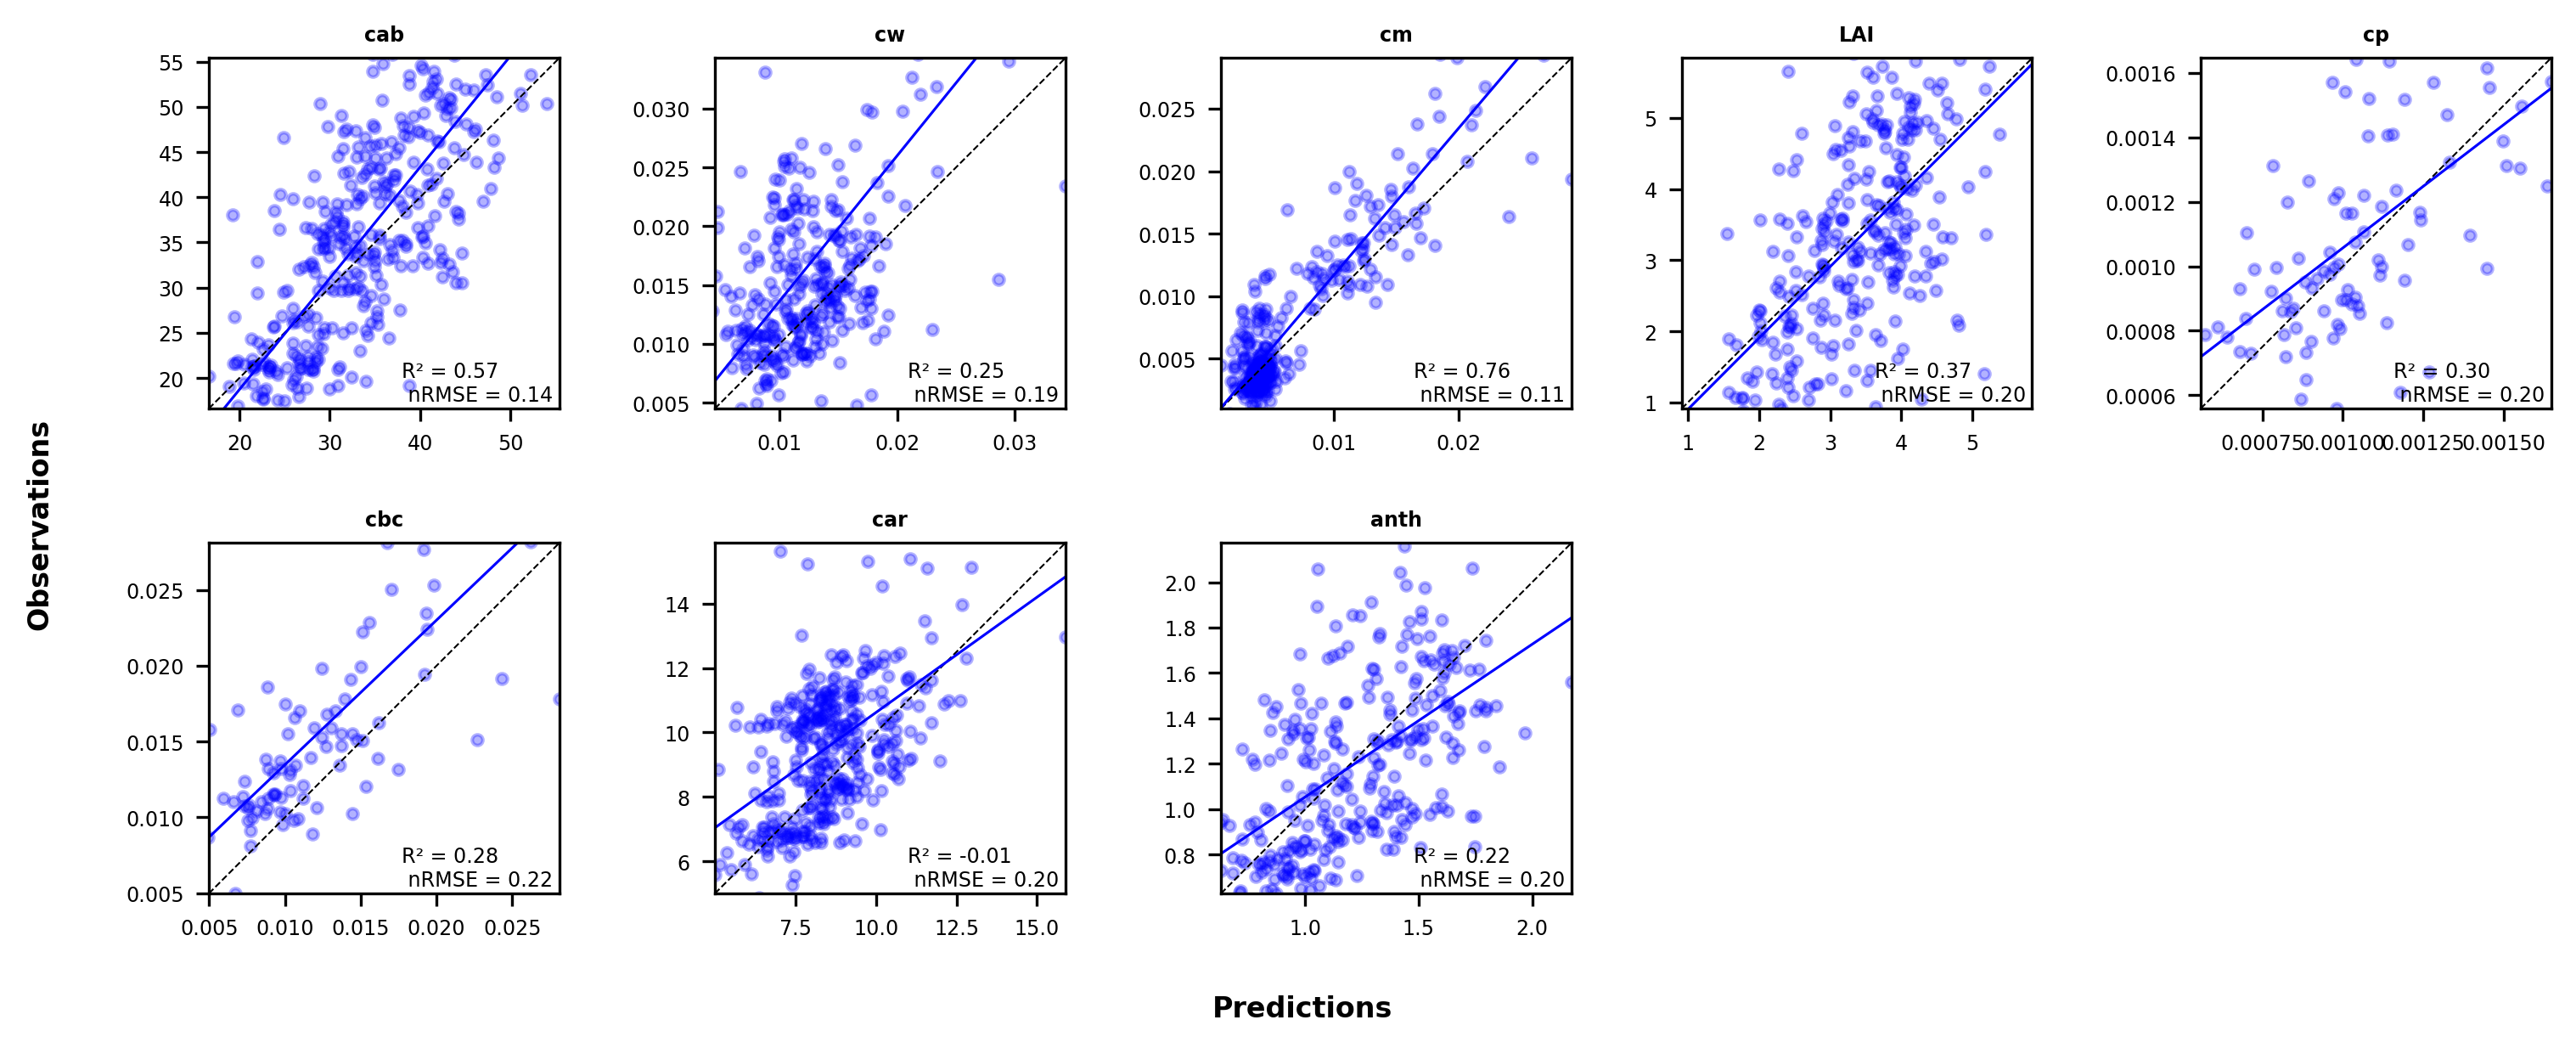

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

import seaborn as sns

size = 5.7
quantile_vis = 1
# test_tr = Traits[:-1]
figsize = (10,4)

plt.rc('font', size=size) #5.7
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.5

a = 2 # number of rows
b = 5  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize = figsize,dpi=300 ,constrained_layout=True)
Traits = test_tr = list(ori_lb.columns)

for tr in range(len(test_tr)):
        
    pred = df_tr_val.iloc[:,tr]
    true = ori_lb.iloc[:,tr]
    
    norm = (np.nanquantile(true, 0.99) - np.nanquantile(true, 0.01))
    
    f = pred.copy().reset_index(drop=True)
    y = true.copy().reset_index(drop=True)
    
    idx = np.union1d(f[f.isna()].index,y[y.isna()].index)
    
    f.drop(idx, axis = 0, inplace=True)
    y.drop(idx, axis = 0, inplace=True)
    
    r2 = r2_score(y,f)
    nrmse = math.sqrt(mean_squared_error(y,f))/norm
    nmae = mean_absolute_error(y,f)/norm

    ax1 = plt.subplot(a, b, c)
    plt.axis('square')
    
    lim_max = min(f.quantile(quantile_vis),y.quantile(quantile_vis)) 
    lim_min = max(f.quantile(1-quantile_vis),y.quantile(1-quantile_vis))
    
    #######
    ax1.set_xlim(lim_min,lim_max)
    ax1.set_ylim(ax1.get_xlim())
    ax1.set_aspect('equal', adjustable='box')

    sns.lineplot(x=(lim_min,lim_max), y=(lim_min,lim_max), ax = ax1, color='black',legend='full', linestyle='dashed')

    sns.regplot(x= pred, color='b', y=true,fit_reg= True,ax=ax1, ci=False, scatter_kws={"color": "blue", 'alpha':0.3})
    # sns.regplot(x= f, y=y, color='b', fit_reg= True, ax=ax1, scatter=False)

    ann = 'R² = {0:.2f} \n nRMSE = {1:.2f}'.format(r2, nrmse)
    
    ax1.annotate(ann,
    xy=(0.55,0.01),
    xycoords='axes fraction',
    horizontalalignment='left',
    verticalalignment='bottom',size=size)

    ann = test_tr[tr]
    ax1.set_title(ann, y=1.1, pad=-5, fontdict = {'fontsize':size,
    'horizontalalignment': 'center', 'fontweight':'bold'})
    
    plt.xlabel(" ")
    plt.ylabel(" ")
    
    c+=1

fig.supxlabel('Predictions', size=8, fontweight='bold', ha='center')
fig.supylabel('Observations', size=8, fontweight='bold', ha='center')

### embedding ##

In [37]:
X_test_lb = torch.tensor(X_val.values.astype('float32')).unsqueeze(dim=1).to(device)

z_train = torch.randn(X_test_lb.shape[0], latent_dim).to(device)

X_train_unlb = fr_unsup.sample(X_test_lb.shape[0], replace=True ,random_state = 20)
X_train_unlb = torch.tensor(X_train_unlb.values.astype('float32')).unsqueeze(dim=1).to(device)

# X_train_unlb

<Axes: >

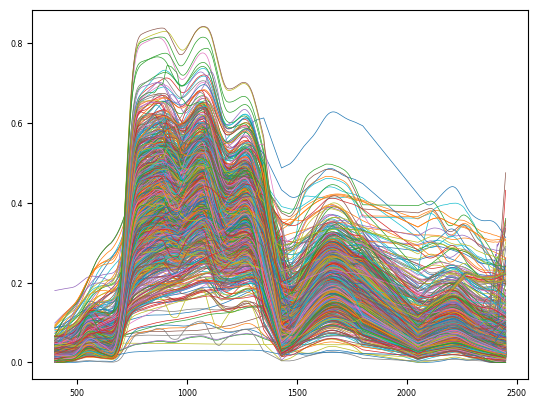

In [38]:
X_val.T.plot(legend=False)

In [39]:
X_train_unlb.shape

torch.Size([1127, 1, 1721])

In [40]:
f_fake_vis = test.D(test.G(z_train))[1] ### feature  tf.reduce_mean(f_lb_vis, 0)
f_lb_vis = test.D(X_test_lb[:,:,:-1])[1] ### feature
f_unlb_vis = test.D(X_train_unlb[:,:,:-1])[1]    ### feature

In [41]:
from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

tsme_embedded_fake = TSNE(n_components=2).fit_transform(f_fake_vis.squeeze().view(f_fake_vis.size(0), -1).detach().cpu().numpy())
tsme_embedded_lb = TSNE(n_components=2).fit_transform(f_lb_vis.squeeze().view(f_lb_vis.size(0), -1).cpu().detach().numpy())
tsme_embedded_unlb = TSNE(n_components=2).fit_transform(f_unlb_vis.squeeze().view(f_unlb_vis.size(0), -1).detach().cpu().numpy())

# embedded_features_unlb = tsne.fit_transform(f_unlb_vis.squeeze().view(f_unlb_vis.size(0), -1).cpu().numpy())

# fig, ax = plt.subplots(figsize=(10, 5))

# x = tsme_embedded_fake[:, 0]
# y = tsme_embedded_fake[:, 1]
# ax.scatter(x,y)

# x = tsme_embedded_lb[:, 0]
# y = tsme_embedded_lb[:, 1]
# ax.scatter(x,y)

# x = tsme_embedded_unlb[:, 0]
# y = tsme_embedded_unlb[:, 1]
# ax.scatter(x,y)

# ax.legend(['Fake data', 'Labeled data', 'Unlabeled data'])

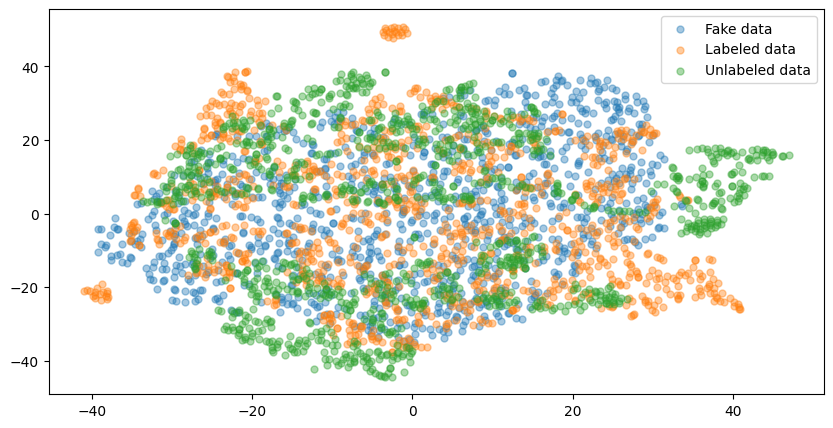

In [52]:
plt.rc('font', size=10) #5.7
plt.rcParams['lines.markersize'] = 5
# plt.rcParams['lines.linewidth'] = 0.5

fig, ax = plt.subplots(figsize=(10, 5))

x = tsme_embedded_fake[:, 0]
y = tsme_embedded_fake[:, 1]
ax.scatter(x,y, alpha=0.4)

x = tsme_embedded_lb[:, 0]
y = tsme_embedded_lb[:, 1]
ax.scatter(x,y, alpha=0.4)

x = tsme_embedded_unlb[:, 0]
y = tsme_embedded_unlb[:, 1]
ax.scatter(x,y, alpha=0.4)

ax.legend(['Fake data', 'Labeled data', 'Unlabeled data'])

In [53]:
tsme_embedded_lb[:, 0].shape

(1127,)

In [54]:
meta_val.LandCover.values

array(['Mix', nan, 'Grassland', ..., 'Crops', 'Shrubland', 'Shrubland'],
      dtype=object)

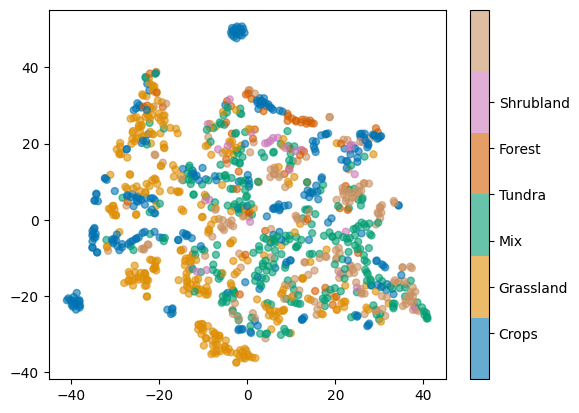

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
import seaborn as sns

# Assuming tsme_embedded_lb is already defined and is a numpy array
x = tsme_embedded_lb[:, 0]
y = tsme_embedded_lb[:, 1]

# Define the land cover types
land_cover_types = ['Crops', 'Grassland', 'Mix', 'Tundra', 'Forest','Shrubland'] #meta_val['LandCover'].unique()

# Create a color palette using seaborn and convert it to a ListedColormap
palette = sns.color_palette("colorblind", len(land_cover_types))
cmap = mcolors.ListedColormap(palette)

# Map LandCover to numeric values for coloring
land_cover_codes = meta_val['LandCover'].astype('category').cat.codes

# Plotting the scatter plot
fig, ax = plt.subplots()

# Scatter plot with categorical coloring using cmap
scatter = ax.scatter(x, y, alpha=0.6, c=land_cover_codes, cmap=cmap)

# Add a color bar with discrete ticks
cbar = plt.colorbar(scatter, ax=ax, ticks=np.arange(len(land_cover_types)))
cbar.set_ticklabels(land_cover_types)

# Show the plot
plt.show()


In [ ]:
land_cover_types